In [1]:
import torch
import numpy as np
import random

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from ucimlrepo import fetch_ucirepo 

from noise_schedulers import LinearScheduler
from tempering import TemperingLearningRegression
from models import MLP

seed = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print ("Device: ", device)
print ("Seed: ", seed)

# set random seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

Device:  cuda
Seed:  42


In [2]:
# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
  
# data (as pandas dataframes) 
X = wine_quality.data.features.to_numpy()
y = wine_quality.data.targets.to_numpy()

# train test split
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)

X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

# summary of the dataset
print ("X_train shape: ", X_train.shape)
print ("y_train shape: ", y_train.shape)
print ("X_test shape: ", X_test.shape)
print ("y_test shape: ", y_test.shape)

X_train shape:  torch.Size([5197, 11])
y_train shape:  torch.Size([5197, 1])
X_test shape:  torch.Size([1300, 11])
y_test shape:  torch.Size([1300, 1])


In [3]:
N = X_train.shape[0]
n = 100
m = 10
T = 1000
burn_in_steps = 10
MC_steps = 20
lr = 1e-5
zeta = 1.0
tau = 1.0

In [13]:
noise_scheudler = LinearScheduler(T=T, init_sigma=0.1)
D = noise_scheudler.transform(y_train)
sigmas = noise_scheudler.sigmas
D[-1,:,:]

tensor([[5.],
        [7.],
        [6.],
        ...,
        [5.],
        [5.],
        [5.]], device='cuda:0')

In [6]:
model = MLP(X_train.shape[-1], [10, 10], 1).to(device)
model

MLP(
  (network): Sequential(
    (0): Linear(in_features=11, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [7]:
trainer = TemperingLearningRegression(
    D = D,
    X = X_train,
    model = model,
    sigmas = sigmas,
    tau = tau,
    zeta = zeta,
    lr = lr,
    burn_in_steps=burn_in_steps,
    MC_steps=MC_steps,
    n = n,
    m = m,
    X_test = X_test,
    y_test = y_test
)

In [10]:
train_loss, test_loss = trainer.train()

  4%|▍         | 40/1000 [00:03<01:24, 11.30it/s]


KeyboardInterrupt: 

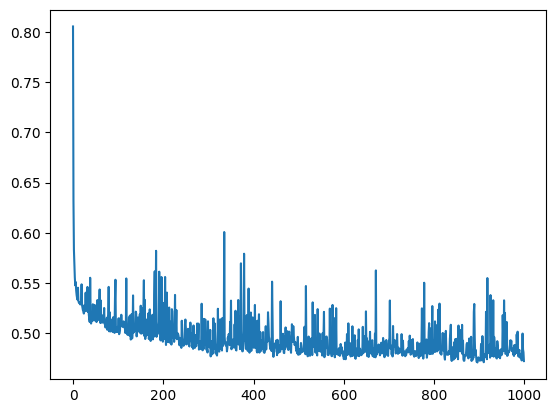

In [11]:
plt.plot(np.arange(len(train_loss)), train_loss, label="Train Loss")

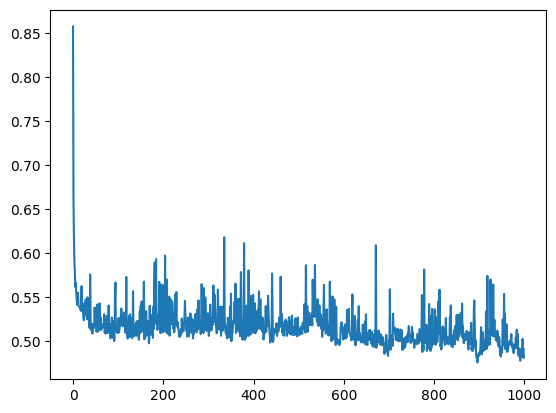

In [12]:
plt.plot(np.arange(len(test_loss)), test_loss, label="Test Loss")